# ****Quantum Generative Adversarial Network****

## **Generative Adversarial Networks (GANs)**
- The main objective of GANs is to generate data that resembles the original data used in the training. To achieve this, two neural networks are trained simultaneously, a generator and a discriminator. 
- The generator has to create fake data similar to the original data used in the training, while the discriminator has to identify the fake data from the real one.
- During training, both the networks iteratively improve off of each other's outputs. By the end of the training, the generator should be able to create data very similar to the original data.

## **Advantages of using Quantum Circuits in GANs**
- GANs are at the forefront of image generation and video processing. However, the enormous amount of computation make them approach the classical computational limit.
- Theoretical works have shown that quantum generative models may possess an exponential advantage over classical GANs.

## **How do QGANs work?**
- In a Quantum GAN model, the generator has a number of sub-generators, which generate patches in parallel with each other. The patches are then concatenated together to produce a single image which is then fed to the discriminator.


We will be using the pennylane library to generate qubits for image generation in parts simultaneously, and pytorch to load our hand-written images, create our machine learning model and train the model.

In [25]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

- We need a custom dataloader which loads the training dataset of handwritten images, which has been implemented in the following cell.
- The function 'filter_by_label' is used to choose the digits we want to use for this implementation. We have chosen the label '0', which means that the dataloader will load the images of zeroes as the training data.

In [26]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label=0, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0

In [27]:
image_size = 8  # Height / width of the square images
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(csv_file="QGAN_data/optdigits.tra", transform=transform)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

We plot the training dataset to get an idea of what the generator will try to replicate.

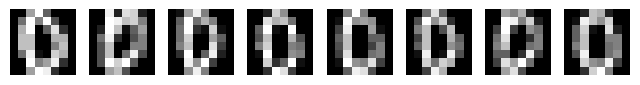

In [28]:
plt.figure(figsize=(8,2))

for i in range(8):
    image = dataset[i][0].reshape(image_size,image_size)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

In [29]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size * image_size, 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

The **Discriminator** is a classical implementation of the Discriminator which uses Linear() for the hidden layers and ReLU() as the activation function. At last, sigmoid function is used to differentiate between real and artificially generated images.

In [30]:
# Quantum variables
n_qubits = 5  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 4  # Number of subgenerators for the patch method / N_G

We define a total of 5 qubits, 4 for each subgenerator and 1 ancillary qubit to perform non-linear transforms on the other qubits.

In [31]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We define the quantum circuit as follows:
- First every qubit is embedded into a state according to the noise.
- This is then followed by a parameterised layer, where each qubit applied on by a RY gate according to the weights.
- Finally, there is a layer of Controlled-Z gates, in which each qubit controls the next qubit.

In [14]:
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister
Q1 = QuantumRegister(1,"Q1")
Q2 = QuantumRegister(1,"Q2")
Q3 = QuantumRegister(1,"Q3")
Q4 = QuantumRegister(1,"Q4")
A = QuantumRegister(1,"A")
M = ClassicalRegister(1,"M")
a = 0

Circuit = QuantumCircuit(M,A,Q1,Q2,Q3,Q4)
Circuit.ry(a,Q1,"Noise")
Circuit.ry(a,Q2,"Noise")
Circuit.ry(a,Q3,"Noise") # All these are rotated according to the noise parameters
Circuit.ry(a,Q4,"Noise")
Circuit.ry(a,A,"Noise")
#Circuit.barrier
Circuit.ry(a,Q1,"Weights")
Circuit.ry(a,Q2,"Weights")
Circuit.ry(a,Q3,"Weights") # Now these qubits are rotated according to the weighted parameters
Circuit.ry(a,Q4,"Weights")
Circuit.ry(a,A,"Weights")

Circuit.cz(A,Q1)
Circuit.cz(Q1,Q2)
Circuit.cz(Q2,Q3)
Circuit.cz(Q3,Q4)

Circuit.measure(A,M) 

display(Circuit.draw())

┌──────────┐┌────────────┐      ┌─┐      
  A: ┤ Noise(0) ├┤ Weights(0) ├─■────┤M├──────
     ├──────────┤├────────────┤ │    └╥┘      
 Q1: ┤ Noise(0) ├┤ Weights(0) ├─■──■──╫───────
     ├──────────┤├────────────┤    │  ║       
 Q2: ┤ Noise(0) ├┤ Weights(0) ├────■──╫──■────
     ├──────────┤├────────────┤       ║  │    
 Q3: ┤ Noise(0) ├┤ Weights(0) ├───────╫──■──■─
     ├──────────┤├────────────┤       ║     │ 
 Q4: ┤ Noise(0) ├┤ Weights(0) ├───────╫─────■─
     └──────────┘└────────────┘       ║       
M: 1/═════════════════════════════════╩═══════
                                      0

The non-linear transform is implemented using the partial_measure function. The ancillary qubit is measured and the probabilities of the other vectors are adjusted accordingly.

In [32]:
@qml.qnode(dev, diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))


# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

We now define the **Quantum Generator**. The forward function implements the partial_measure according to elem and params from the discriminator's output. According to the output, a new set of 8 images is returned and fed to the discriminator, and the cycle continues until the specified number of iterations is reached.

In [33]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images

In [34]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 500  # Number of training iterations

- The following cell contains the code for training the generator and the discriminator for 500 iterations.
- The loss function (criterion) used is Binary Cross Entropy function offered by nn module in Pytorch. 
- The optimizer class, Stochastic Gradient Descent, is used in the learning of both the discriminator and the generator.

In [35]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []

while True:
    for i, (data, _) in enumerate(dataloader):

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        # Noise following a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1

        # Show loss values
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            test_images = generator(fixed_noise).view(8,1,image_size,image_size).cpu().detach()

            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)

        if counter == num_iter:
            break
    if counter == num_iter:
        break

Iteration: 10, Discriminator Loss: 1.361, Generator Loss: 0.596
Iteration: 20, Discriminator Loss: 1.351, Generator Loss: 0.604
Iteration: 30, Discriminator Loss: 1.308, Generator Loss: 0.624
Iteration: 40, Discriminator Loss: 1.302, Generator Loss: 0.628
Iteration: 50, Discriminator Loss: 1.270, Generator Loss: 0.655
Iteration: 60, Discriminator Loss: 1.309, Generator Loss: 0.607
Iteration: 70, Discriminator Loss: 1.252, Generator Loss: 0.652
Iteration: 80, Discriminator Loss: 1.302, Generator Loss: 0.594
Iteration: 90, Discriminator Loss: 1.254, Generator Loss: 0.615
Iteration: 100, Discriminator Loss: 1.290, Generator Loss: 0.593
Iteration: 110, Discriminator Loss: 1.198, Generator Loss: 0.659
Iteration: 120, Discriminator Loss: 1.294, Generator Loss: 0.594
Iteration: 130, Discriminator Loss: 1.262, Generator Loss: 0.624
Iteration: 140, Discriminator Loss: 1.260, Generator Loss: 0.600
Iteration: 150, Discriminator Loss: 1.259, Generator Loss: 0.615
Iteration: 160, Discriminator Loss

- We can observe that while the Discriminator Loss values are decreasing, the generator loss values go on increasing. This is because the loss function in the generator is set up such that instead of minimising the (1 - log(D)) term, we have to maximize log(D), where D is the accuracy of the discriminator to tell real apart from the fake ones.
- This is the reason the generator loss values are increasing. Inspite of this, both the discriminator and generator are becoming better at classifying real vs fake images and generating better images respectively.

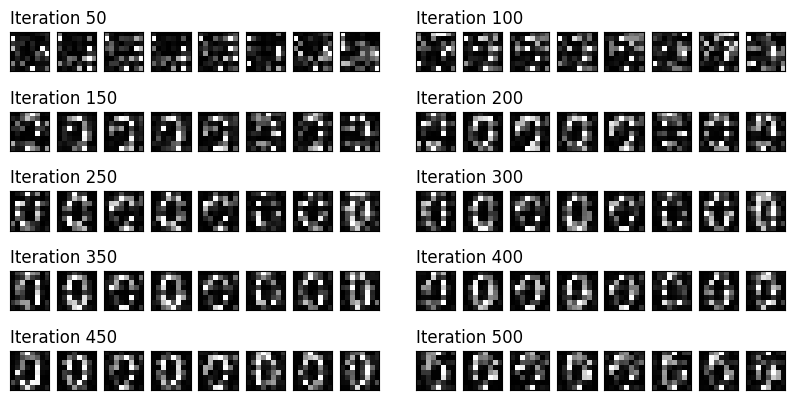

In [36]:
fig = plt.figure(figsize=(10, 5))
outer = gridspec.GridSpec(5, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()

We can observe the generated images approaching the likes of original data with more and more number of iterations.